### R-CNN Implementation Using Keras

## Step 1: read in dataset and draw bounding boxes on images

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image
from PIL.ImageDraw import Draw


## Step 2: start building model

In [2]:
width = 416
height = 416
num_classes = 3
classes = ["Crab", "Shrimp", "Lobster"]

In [3]:
TRAINING_CSV_FILE = '/content/shellfish_dataset/train/_annotations.csv'
VALIDATION_CSV_FILE = '/content/shellfish_dataset/valid/_annotations.csv'
TRAINING_IMAGE_DIR = '/content/shellfish_dataset/train'
VALIDATION_IMAGE_DIR = '/content/shellfish_dataset/valid'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
validation_image_records = pd.read_csv(VALIDATION_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
validation_image_path = os.path.join(os.getcwd(), VALIDATION_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():

    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)


    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)

    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))



validation_images = []
validation_targets = []
validation_labels = []

for index, row in validation_image_records.iterrows():

    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    validation_image_fullpath = os.path.join(validation_image_path, filename)
    validation_img = keras.preprocessing.image.load_img(validation_image_fullpath, target_size=(height, width))
    validation_img_arr = keras.preprocessing.image.img_to_array(validation_img)

    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)

    validation_images.append(validation_img_arr)
    validation_targets.append((xmin, ymin, xmax, ymax))
    validation_labels.append(classes.index(class_name))

In [4]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

In [5]:
#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)

In [6]:
#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)


In [7]:
model = tf.keras.Model(input_layer, outputs=[classifier_branch, locator_branch])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 bl_1 (Rescaling)            (None, 416, 416, 3)          0         ['input_1[0][0]']             
                                                                                                  
 bl_2 (Conv2D)               (None, 416, 416, 16)         448       ['bl_1[0][0]']                
                                                                                                  
 bl_3 (MaxPooling2D)         (None, 208, 208, 16)         0         ['bl_2[0][0]']                
                                                                                              

In [9]:
for layer in model.layers:
    if layer.name.startswith('bl_'):
        print(layer.name)
        layer.trainable = False

for layer in model.layers:
    if layer.name.startswith('bb_'):
        print(layer.name)
        layer.trainable = False

bl_1
bl_2
bl_3
bl_4
bl_5
bl_6
bl_7
bl_8
bb_1
bb_2
bb_3
bb_head


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 bl_1 (Rescaling)            (None, 416, 416, 3)          0         ['input_1[0][0]']             
                                                                                                  
 bl_2 (Conv2D)               (None, 416, 416, 16)         448       ['bl_1[0][0]']                
                                                                                                  
 bl_3 (MaxPooling2D)         (None, 208, 208, 16)         0         ['bl_2[0][0]']                
                                                                                              

In [11]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tf.keras.losses.MSE}


In [12]:
classes = ["Crab", "Shrimp", "Lobster"]

model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [13]:
TRAINING_CSV_FILE = '/content/shellfish_dataset/train/_annotations.csv'
TESTING_CSV_FILE = '/content/shellfish_dataset/test/_annotations.csv'
TRAINING_IMAGE_DIR = '/content/shellfish_dataset/train'
TESTING_IMAGE_DIR = '/content/shellfish_dataset/test'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
testing_image_records = pd.read_csv(TESTING_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
test_image_path = os.path.join(os.getcwd(), TESTING_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():

    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)


    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)

    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))

test_images = []
test_targets = []
test_labels = []

for index, row in testing_image_records.iterrows():

    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    test_image_fullpath = os.path.join(test_image_path, filename)
    test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width))
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    #img_arr = img_arr/255.0

    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)

    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(classes.index(class_name))

In [14]:
training_epochs = 20

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)

In [15]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}

testTargets = {
    "cl_head": test_labels,
    "bb_head": test_targets
}

In [16]:
history = model.fit(train_images, trainTargets,
                   validation_data=(test_images, testTargets),
                   batch_size=4,
                   epochs=training_epochs,
                   shuffle=True,
                   verbose=1)

Epoch 1/20
215/215 [==============================] - 116s 532ms/step - loss: 2.2681 - cl_head_loss: 2.1729 - bb_head_loss: 0.0952 - cl_head_accuracy: 0.6049 - bb_head_accuracy: 0.4510 - val_loss: 1.3838 - val_cl_head_loss: 1.2876 - val_bb_head_loss: 0.0962 - val_cl_head_accuracy: 0.6379 - val_bb_head_accuracy: 0.5000
Epoch 2/20
215/215 [==============================] - 121s 564ms/step - loss: 1.0461 - cl_head_loss: 0.9508 - bb_head_loss: 0.0952 - cl_head_accuracy: 0.7284 - bb_head_accuracy: 0.4510 - val_loss: 1.1925 - val_cl_head_loss: 1.0963 - val_bb_head_loss: 0.0962 - val_cl_head_accuracy: 0.5431 - val_bb_head_accuracy: 0.5000
Epoch 3/20
215/215 [==============================] - 113s 527ms/step - loss: 0.6658 - cl_head_loss: 0.5706 - bb_head_loss: 0.0952 - cl_head_accuracy: 0.7937 - bb_head_accuracy: 0.4510 - val_loss: 1.5068 - val_cl_head_loss: 1.4107 - val_bb_head_loss: 0.0962 - val_cl_head_accuracy: 0.6379 - val_bb_head_accuracy: 0.5000
Epoch 4/20
215/215 [====================

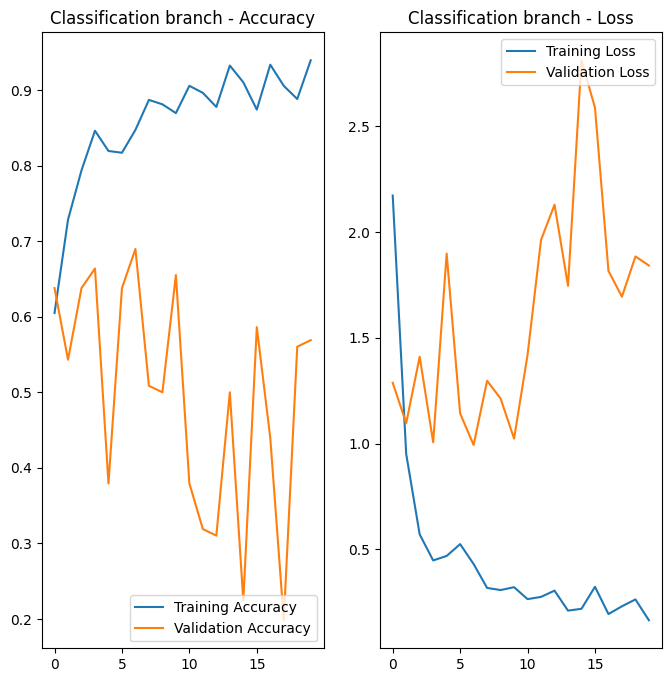

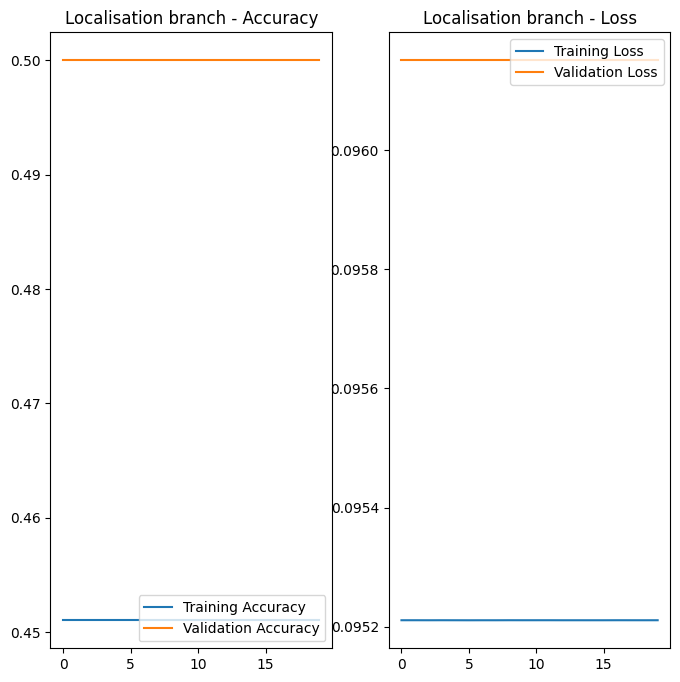

In [17]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



epochs_range = range(training_epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

## Step 3: Test Model

1/1 [==============================] - 0s 290ms/step
[array([[ 1.0309485, -7.121685 ,  7.785425 ]], dtype=float32), array([[0.52879757, 0.5230275 , 0.47087425, 0.53157306]], dtype=float32)]
['Crab', 'Shrimp', 'Lobster']
2
Lobster
1/1 [==============================] - 0s 89ms/step
[array([[ 2.4631474 ,  3.8600492 , -0.20648652]], dtype=float32), array([[0.51151234, 0.5191101 , 0.4683416 , 0.5297513 ]], dtype=float32)]
['Crab', 'Shrimp', 'Lobster']
1
Shrimp
1/1 [==============================] - 0s 78ms/step
[array([[3.4210222, 0.1004227, 3.0900788]], dtype=float32), array([[0.5187556 , 0.51757145, 0.46403593, 0.53921604]], dtype=float32)]
['Crab', 'Shrimp', 'Lobster']
0
Crab
1/1 [==============================] - 0s 94ms/step
[array([[4.4743004 , 3.8604264 , 0.31051213]], dtype=float32), array([[0.5086771 , 0.5143015 , 0.45970395, 0.52562124]], dtype=float32)]
['Crab', 'Shrimp', 'Lobster']
0
Crab
1/1 [==============================] - 0s 91ms/step
[array([[-0.24836597,  3.3169127 , -1.

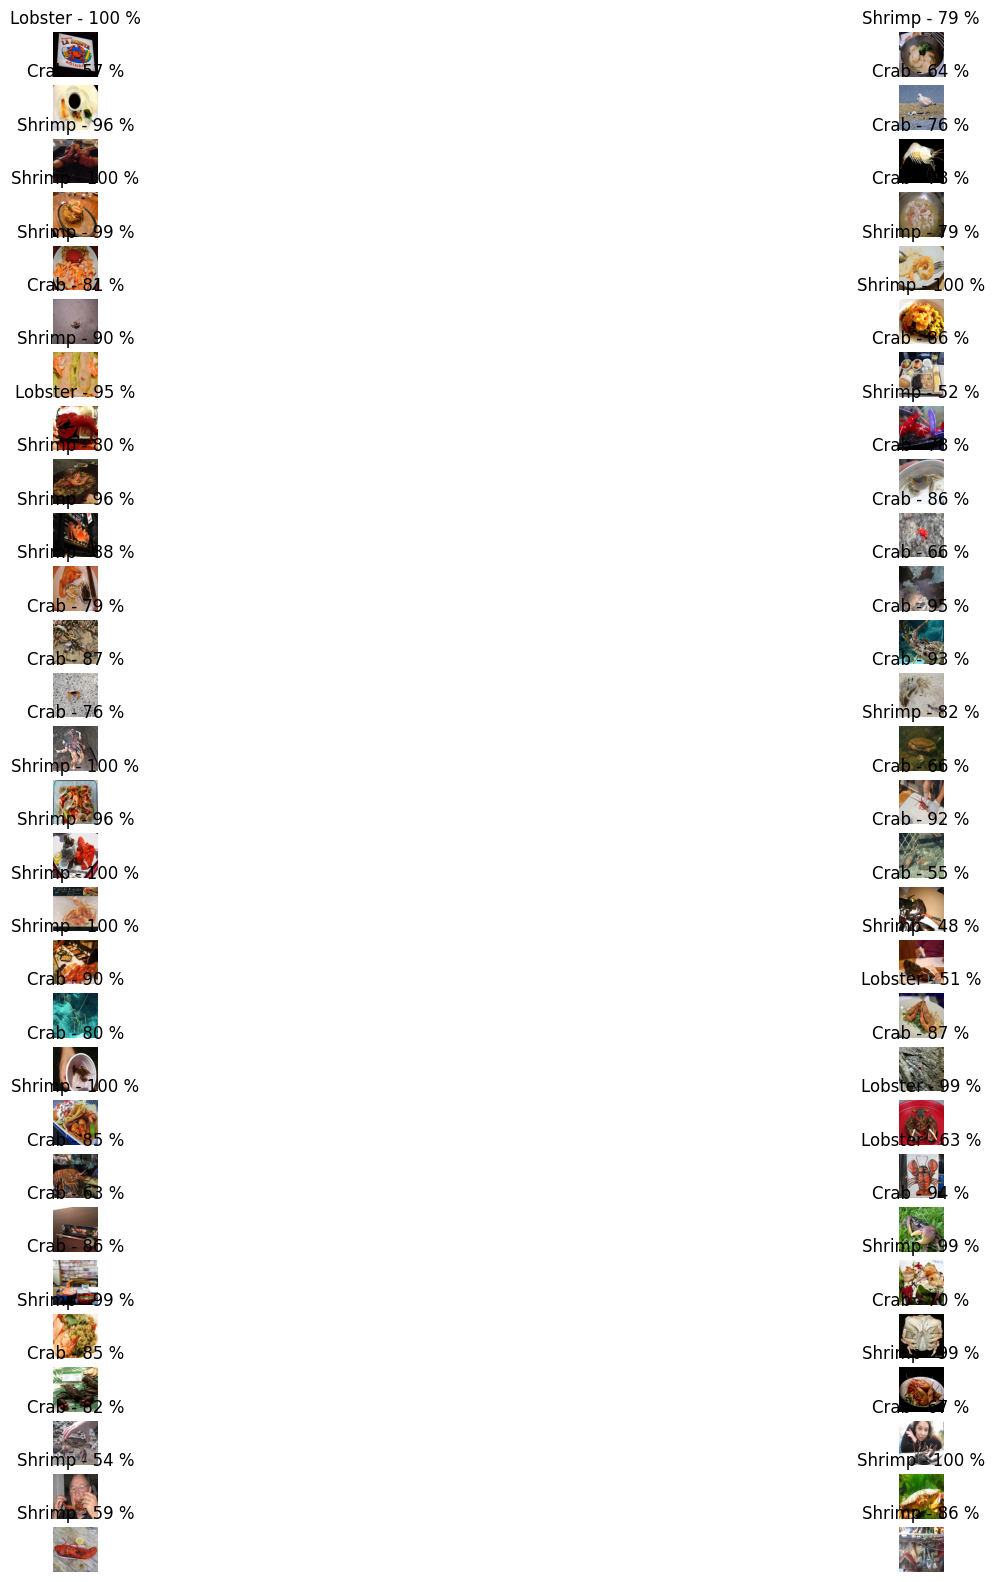

In [18]:
test_dir = pathlib.Path('/content/shellfish_dataset/test')
# test_dir = '/content/shellfish_dataset/test'
img_paths = list(test_dir.glob('*.jpg'))

plt.figure(figsize=(20, 20))
#print(len(img_paths))

for i, img_path in enumerate(img_paths):
    shellfish_img = keras.preprocessing.image.load_img(img_path, target_size=(height, width))
    img_arr = keras.preprocessing.image.img_to_array(shellfish_img)
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)
    print(predictions)

    score = tf.nn.softmax(predictions[0][0])

    percent = int(round(100*np.max(score), 0))
    print(classes)
    print(np.argmax(score))
    print(classes[np.argmax(score)])
    class_name = classes[np.argmax(score)]
    title = "{} - {} %".format(class_name, percent)

    bbox = predictions[1][0]
    bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]

    if class_name == 'Shrimp':
        draw1 = Draw(shellfish_img)
        draw1.rectangle(bbox, outline='yellow', width=2)

    if class_name == 'Lobster':
        draw1 = Draw(shellfish_img)
        draw1.rectangle(bbox, outline='red', width=2)

    if class_name == 'Crab':
        draw1 = Draw(shellfish_img)
        draw1.rectangle(bbox, outline='blue', width=2)

    ax = plt.subplot(29, 2, i+1)
    plt.imshow(shellfish_img)
    plt.title(title)
    plt.axis("off")